Epoch 0 Training loss 1.0026551915120474 Validation Loss : 0.784060150384903
Epoch 1 Training loss 0.7541430796249003 Validation Loss : 0.7311192870140075
Epoch 2 Training loss 0.7091334001927436 Validation Loss : 0.6912899136543273
Epoch 3 Training loss 0.6795461600339865 Validation Loss : 0.6636345684528351
Epoch 4 Training loss 0.6513798893252506 Validation Loss : 0.6364436328411103
Epoch 5 Training loss 0.6286438115035431 Validation Loss : 0.6127290248870849
Epoch 6 Training loss 0.6068215807781944 Validation Loss : 0.5899698212742805
Epoch 7 Training loss 0.5845904033395308 Validation Loss : 0.5661205962300301
Epoch 8 Training loss 0.5622211358969724 Validation Loss : 0.5419279336929321
Epoch 9 Training loss 0.5388024694557432 Validation Loss : 0.5166514798998832
Epoch 10 Training loss 0.5212507500678678 Validation Loss : 0.4926509499549866
Epoch 11 Training loss 0.4991025543665584 Validation Loss : 0.4711186021566391
Epoch 12 Training loss 0.47578807495817355 Validation Loss : 0.

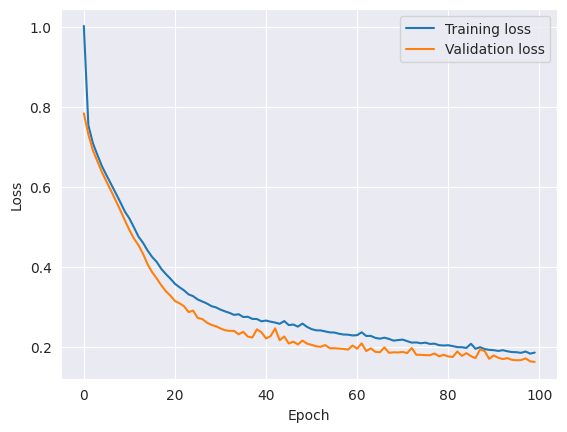

Finished Training


In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random





class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x = torch.tensor(row[0:-1].values, dtype=torch.float32)
        y = torch.tensor([row[-1], 1 - row[-1]], dtype=torch.float32)
        

        return x, y

# Load the training dataset
train_dataset = CustomDataset(csv_file='/content/drive/MyDrive/YapaySinirAglari/cure_the_princess_train.csv')
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load the testing dataset
test_dataset = CustomDataset(csv_file='/content/drive/MyDrive/YapaySinirAglari/cure_the_princess_test.csv')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load the validation dataset
val_dataset = CustomDataset(csv_file='/content/drive/MyDrive/YapaySinirAglari/cure_the_princess_validation.csv')
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)




class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(in_features=13, out_features=100) 
        self.dropout1 = nn.Dropout(p=0.2)
        self.layer2 = nn.Linear(in_features=100, out_features=50)
        self.dropout2 = nn.Dropout(p=0.2)
        self.layer3 = nn.Linear(in_features=50, out_features=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.layer3(x))
        return x




# Set the seed value for random, numpy, and torch
seed_value = 190401012
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)



# Instantiate the model
model = MyNeuralNetwork()


# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01) # add weight_decay for L1 regularization


#train the model

# Set the model to training mode
model.train()

list_train_loss, list_val_loss = [], []
num_epochs = 100
best_val_loss = None
patience_counter = 0
patience = 5

for epoch in range(num_epochs):

    # Set the model to training mode
    #model.train()

    # training loop
    train_loss = 0.0
    train_count = 0.0
    for inputs, labels in train_dataloader:

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_count += 1.0
        train_loss += loss.item()
      

    val_loss = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    #model.train()

    # calculate metrics
    train_loss /= train_count
    val_loss /= len(val_dataloader)

    print("Epoch", epoch, "Training loss", train_loss,"Validation Loss :",val_loss)

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0



sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


print('Finished Training')


In [3]:
# Put the model in evaluation mode
model.eval()

# Initialize the variables for the metrics
tp = 0  # true positives
tn = 0  # true negatives
fp = 0  # false positives
fn = 0  # false negatives

# Iterate over the test data
for inputs, labels in test_dataloader:
    # Make predictions using the model
    outputs = model(inputs)
    predictions = torch.argmax(outputs, dim=1)

    # Compute the metrics
    tp += torch.sum((predictions == 1) & (labels[:, 1] == 1)).item()
    tn += torch.sum((predictions == 0) & (labels[:, 0] == 1)).item()
    fp += torch.sum((predictions == 1) & (labels[:, 0] == 1)).item()
    fn += torch.sum((predictions == 0) & (labels[:, 1] == 1)).item()

# Compute the metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_score))

Accuracy: 0.9249
Precision: 0.9201
Recall: 0.9297
F1 Score: 0.9249
